# Lab 8. Image processing
#### Computational Methods for Geoscience - Fall 2023
#### Instructor: Eric Lindsey

Due: Oct. 31, 2023

---------

#### Install OpenCV...

In [2]:
pip install opencv-python

  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [56]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
import scipy.fft
import scipy.signal
import cv2
import glob
import rasterio
from rasterio.plot import show

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens
# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2

# not used in this lab:

#import netCDF4 as nc
#import datetime
#import scipy.optimize
#import time
#import multiprocessing as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Assignment 1. Re-order the bands of an image and display it
a. Read in the landsat data from 10/16/2023 over Albuquerque, and plot the bands separately.

The bands represent the following information:
- Band 2: Blue
- Band 3: Green
- Band 4: Red
- Band 5: Near-infrared

b. Create an "RGB" composite to view the image in true color. Set the bounds of your plot to view just the area around Albuquerque and the Sandias.

c. Then try computing NDVI using the Red and Near-infrared bands and plot that image.


#### Part a. Plot LandSat Bands

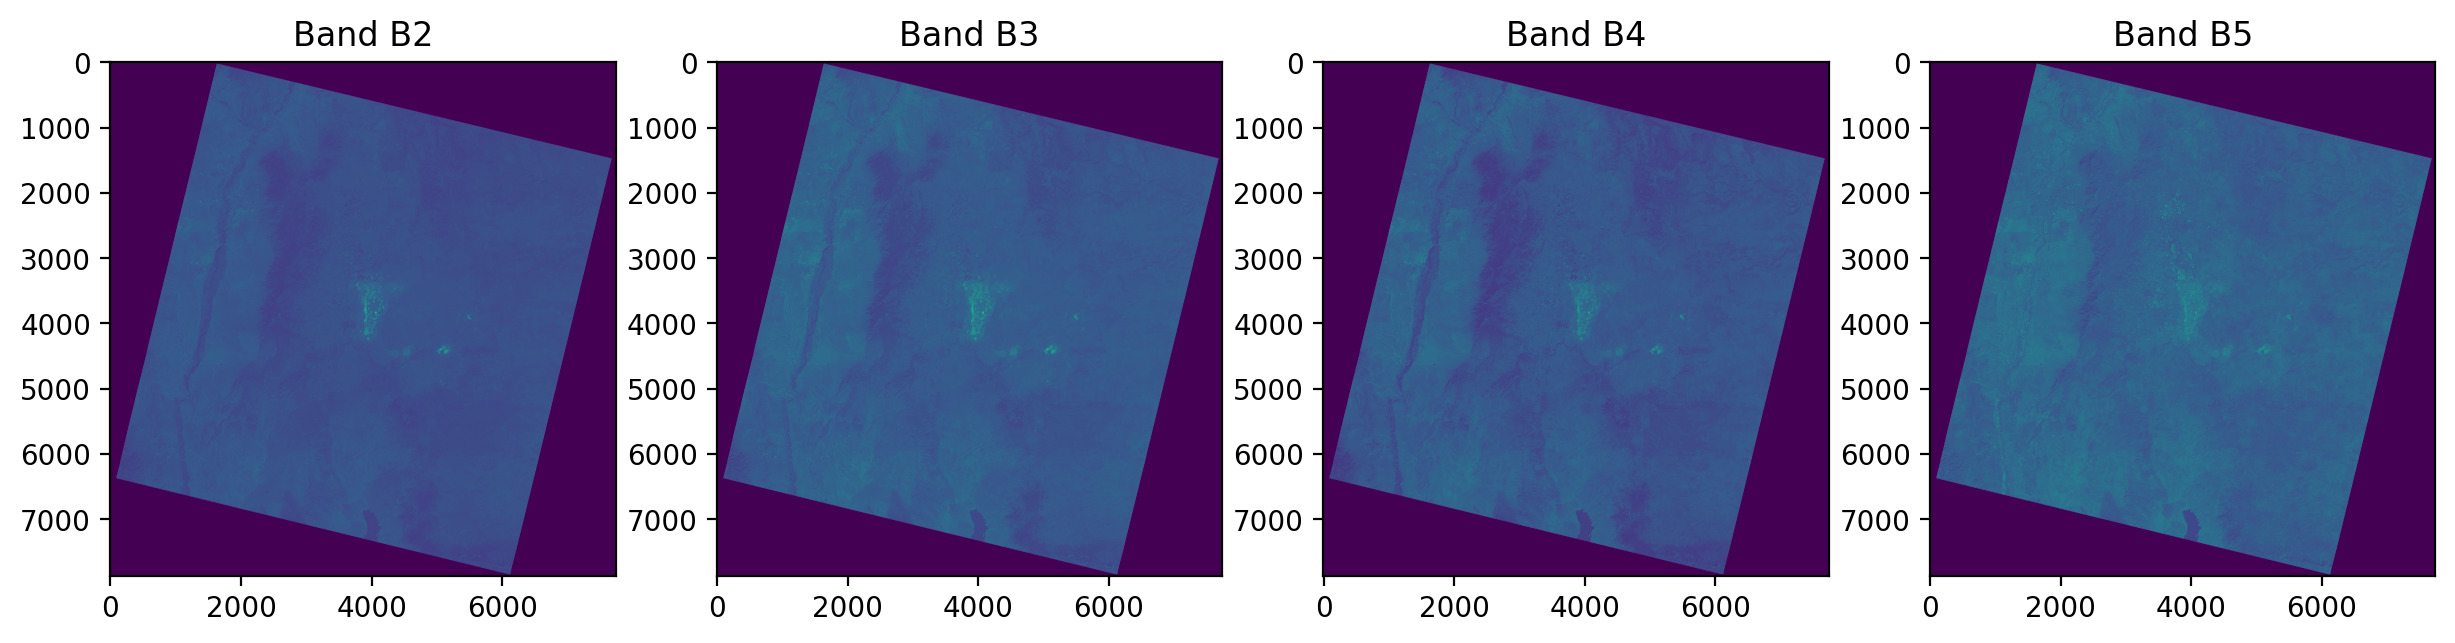

In [50]:
# Directory where the Landsat images are stored
directory_path = r'C:\Users\marzi\OneDrive - University of New Mexico\EPS 522\Labs\Lab 8 Image Analysis\LANDSAT IMGs'

# Define the file pattern to match
file_pattern = 'LC09_L2SP_033036_20231016_20231017_02_T1_SR_B*.tif'

# Use glob to find all matching files
image_files = glob.glob(directory_path + '\\' + file_pattern)

# Plot the images
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))

for i, image_file in enumerate(image_files):
    # Read the image using cv2
    image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)

    # Extract the band name from the file name
    band_name = image_file.split('_')[-1].split('.')[0]

    # Plot the image
    axes[i].imshow(image)
    axes[i].set_title(f'Band {band_name}')

plt.show()


#### Part b. RGB Composite

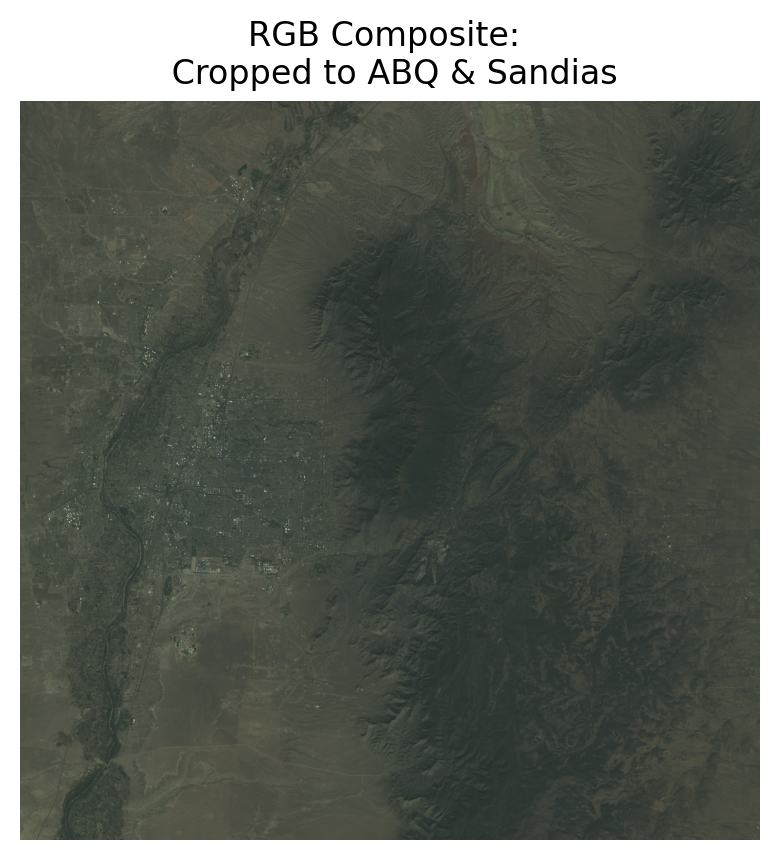

In [75]:
# Directory where the Landsat images are stored
directory_path = r'C:\Users\marzi\OneDrive - University of New Mexico\EPS 522\Labs\Lab 8 Image Analysis\LANDSAT IMGs'

# Define the file patterns for red, green, and blue bands
red_band_pattern = 'LC09_L2SP_033036_20231016_20231017_02_T1_SR_B4.tif'
green_band_pattern = 'LC09_L2SP_033036_20231016_20231017_02_T1_SR_B3.tif'
blue_band_pattern = 'LC09_L2SP_033036_20231016_20231017_02_T1_SR_B2.tif'

# Use glob to find the matching band images
red_band = glob.glob(directory_path + '\\' + red_band_pattern)
green_band = glob.glob(directory_path + '\\' + green_band_pattern)
blue_band = glob.glob(directory_path + '\\' + blue_band_pattern)

# Check if all three bands are found
if len(red_band) == 1 and len(green_band) == 1 and len(blue_band) == 1:
    red_band = red_band[0]
    green_band = green_band[0]
    blue_band = blue_band[0]

    # Read the red, green, and blue bands using cv2
    red = cv2.imread(red_band, cv2.IMREAD_UNCHANGED)
    green = cv2.imread(green_band, cv2.IMREAD_UNCHANGED)
    blue = cv2.imread(blue_band, cv2.IMREAD_UNCHANGED)

    # Ensure data is scaled correctly (0-255 for 8-bit images)
    red = (red / red.max() * 255).astype('uint8')
    green = (green / green.max() * 255).astype('uint8')
    blue = (blue / blue.max() * 255).astype('uint8')

    # Stack the bands to create an RGB image
    rgb_image = cv2.merge([red, green, blue])

    # Define the coordinates of the region of interest (ROI) as a bounding box
    # The format is (x, y, width, height)
    roi_box = (1500, 1000, 2000, 2000)  # Example coordinates; adjust to your desired ROI

    # Crop the RGB composite to the ROI
    x, y, w, h = roi_box
    rgb_image_cropped = rgb_image[y:y + h, x:x + w]

    # Display the cropped RGB composite with the correct colormap
    plt.imshow(rgb_image_cropped)
    plt.title('RGB Composite: \n Cropped to ABQ & Sandias')
    plt.axis('off')
    plt.show()
else:
    print("One or more band files not found.")


#### Part c. Plot NDVI

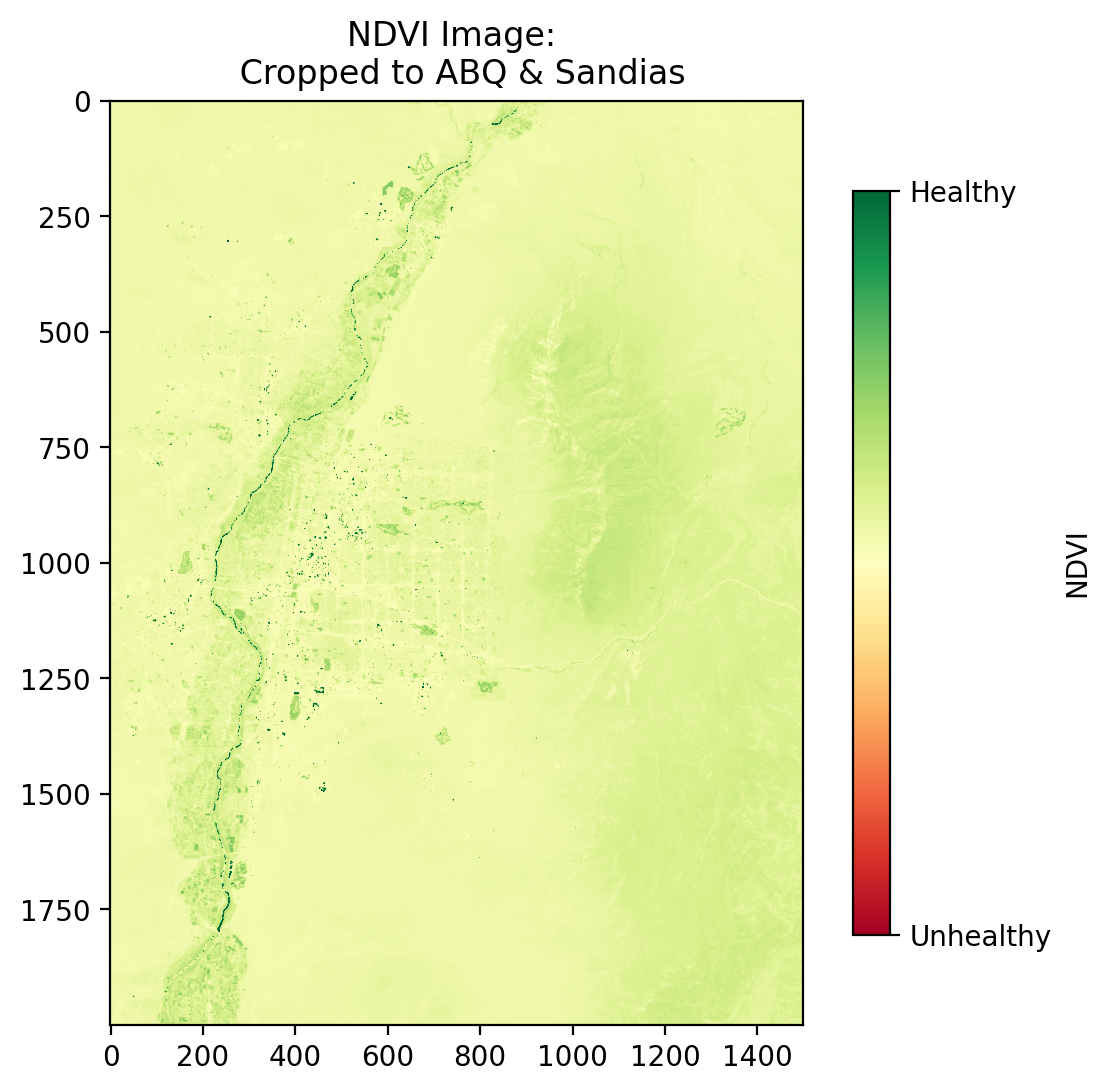

In [79]:
# Directory where the Landsat images are stored
directory_path = r'C:\Users\marzi\OneDrive - University of New Mexico\EPS 522\Labs\Lab 8 Image Analysis\LANDSAT IMGs'

# Define the file patterns for red and near-infrared bands
red_band = "\LC09_L2SP_033036_20231016_20231017_02_T1_SR_B4.tif"
nir_band = "\LC09_L2SP_033036_20231016_20231017_02_T1_SR_B5.tif"

# Define the paths to the red and near-infrared bands
red_band_path = directory_path + red_band
nir_band_path = directory_path + nir_band

# Define the region of interest (ROI) - adjust these coordinates based on your specific area
roi = {
    'top': 1000,
    'bottom': 3000,
    'left': 1500,
    'right': 3000
}

# Open the red band
with rasterio.open(red_band_path) as red_band:
    red_data = red_band.read(1, window=((roi['top'], roi['bottom']), (roi['left'], roi['right'])))

# Open the near-infrared band
with rasterio.open(nir_band_path) as nir_band:
    nir_data = nir_band.read(1, window=((roi['top'], roi['bottom']), (roi['left'], roi['right'])))

# Calculate NDVI
ndvi = (nir_data - red_data) / (nir_data + red_data)

# Plot the NDVI image
plt.figure(figsize=(8, 6))
im = plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

# Add colorbar with custom labels
cbar = plt.colorbar(im, fraction=0.03, pad=0.04)
cbar.set_label('NDVI')
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Unhealthy', 'Healthy'])

plt.title('NDVI Image: \n Cropped to ABQ & Sandias')
plt.show()


### Assignment 2. Filtering the image

Apply the following filters to the grayscale image of my cat Pumpkin, and plot them all together with the original

- 9x9 smoothing
- 9x9 median
- Edge detection

For the last one, use the function 'cv2.canny', which is a common edge detection filter. You'll have to look up how to use it!


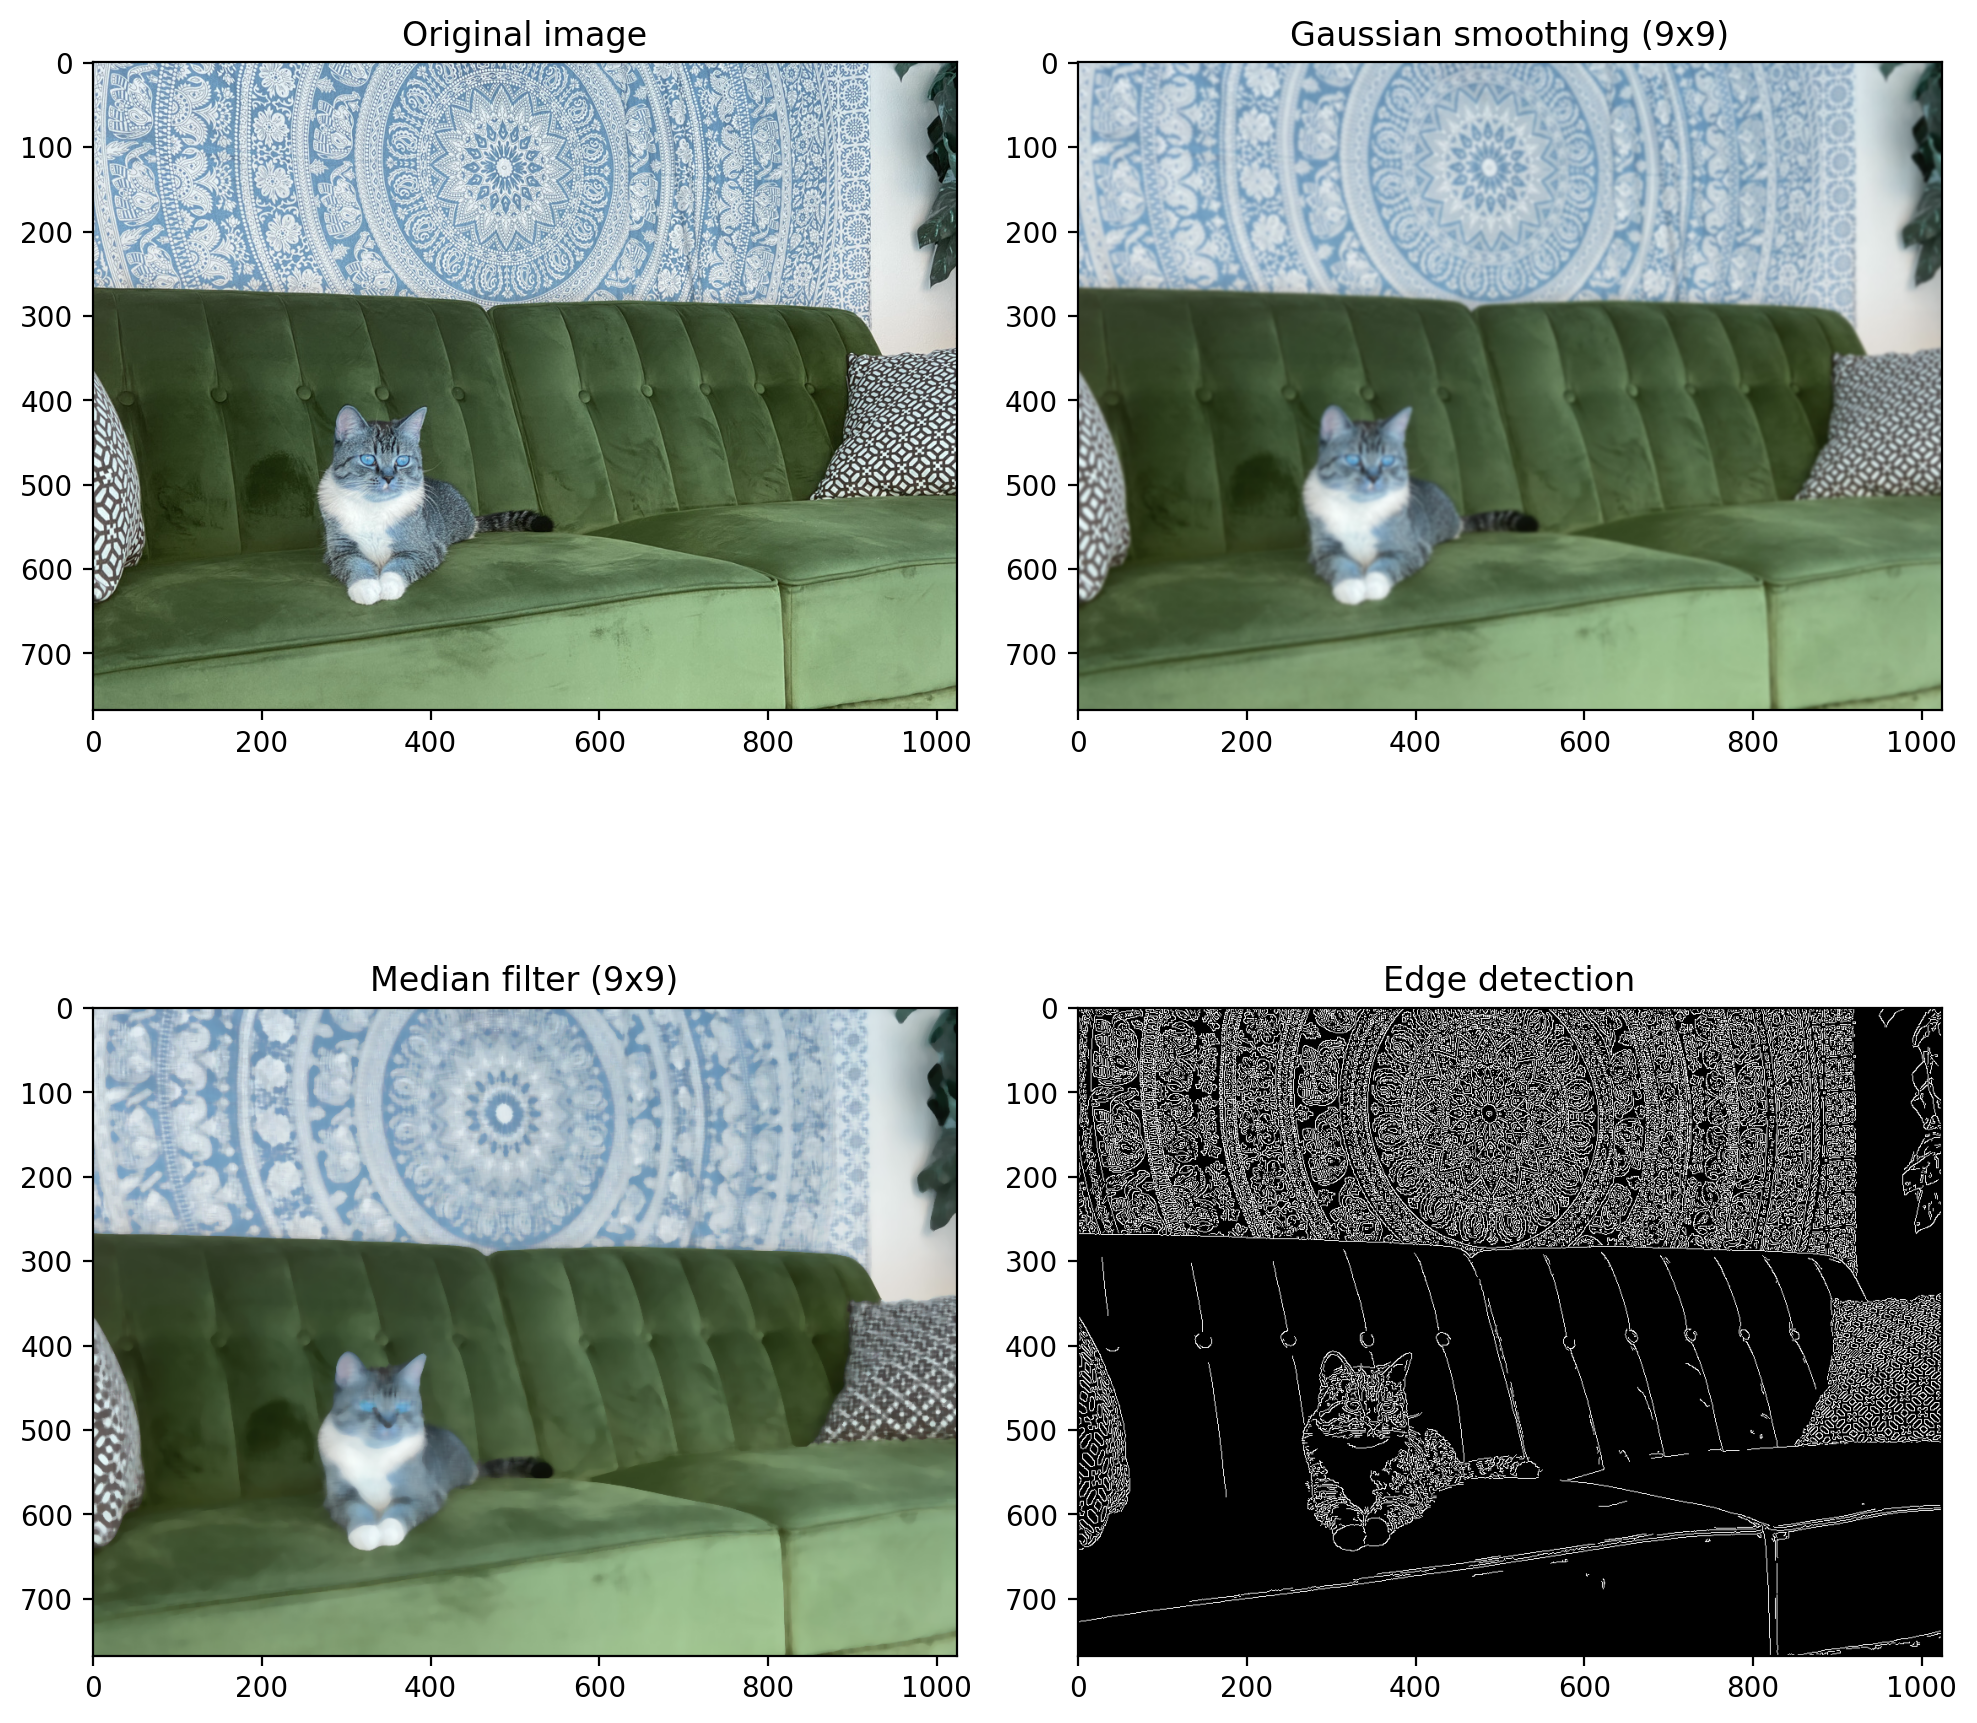

In [15]:
cat = cv2.imread('pumpkin.jpg')

fig,axs=plt.subplots(2,2,figsize=(10,10))

# Original Pumpkin image
axs[0,0].imshow(cat)
axs[0,0].set_title('Original image')

# let's try to filter it with a 9x9 boxcar filter.
smooth = cv2.GaussianBlur(cat, (9, 9), 0)
axs[0,1].imshow(smooth, cmap='gray')
axs[0,1].set_title('Gaussian smoothing (9x9)')

# Median filter
img_median = cv2.medianBlur(cat, 9)
axs[1,0].imshow(img_median, cmap='gray')
axs[1,0].set_title('Median filter (9x9)')

# Edge detection using the Canny filter
edges = cv2.Canny(cat, 100, 200)
axs[1,1].imshow(edges, cmap='gray')
axs[1,1].set_title('Edge detection')

plt.tight_layout()
plt.show()

## Image thresholding and connected components



### Assignment 3: labeling the icebergs on the figure

The information output by the connected components identifier contains other useful information besides just the shape areas. For example, we can get the object centroids within our for loop, with 

    (cx, cy) = centroids[i]
    
and bounding-box information with

    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]

Copy the code above and modify it to plot the original grayscale image, but with a red text label on the figure at the centroid location of each iceberg displaying that iceberg's area if it's larger than your chosen threshold, and draw a bounding box around the largest one.

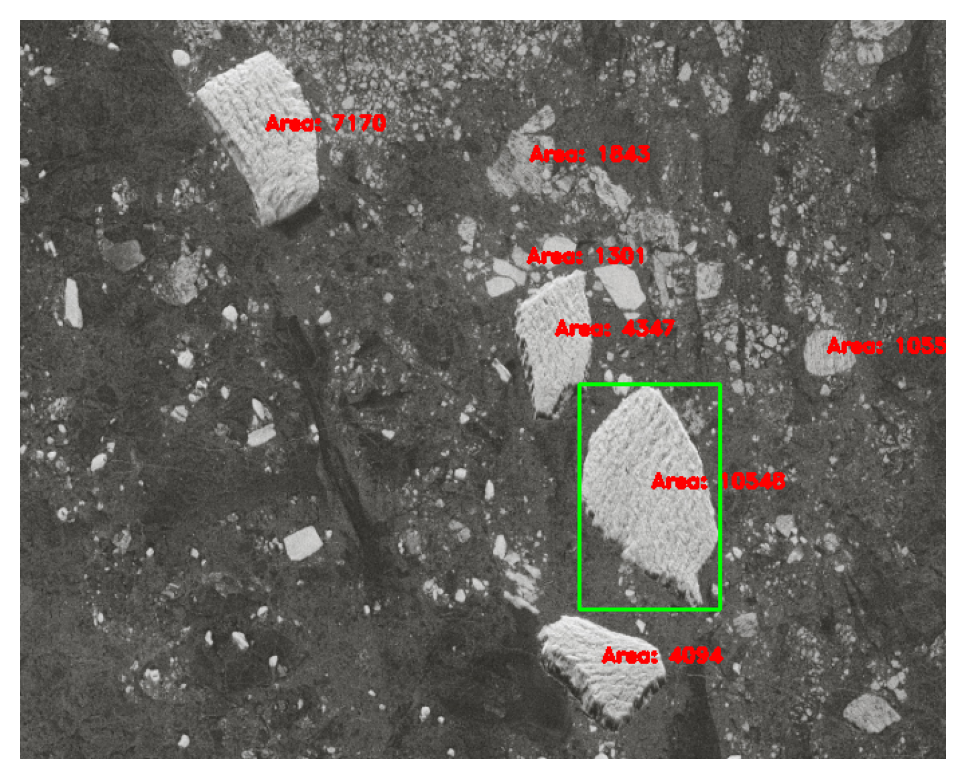

In [79]:
# Load an image
image = cv2.imread("iceye_icebergs.png")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary image
_, binary_image = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# Find connected components
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

# Set your chosen area threshold
area_threshold = 1000  # You can adjust this threshold

largest_iceberg_area = 0
largest_iceberg_bbox = None

for i in range(1, len(stats)):
    # Extract centroid coordinates
    cx, cy = centroids[i]
    
    # Access the area of the iceberg
    area = stats[i, cv2.CC_STAT_AREA]

    if area > area_threshold:
        # Draw a red text label at the centroid
        label = f"Area: {area}"
        cv2.putText(image, label, (int(cx), int(cy)), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 255), 2)

        if area > largest_iceberg_area:
            largest_iceberg_area = area
            largest_iceberg_bbox = (int(stats[i, cv2.CC_STAT_LEFT]), int(stats[i, cv2.CC_STAT_TOP]), int(stats[i, cv2.CC_STAT_WIDTH]), int(stats[i, cv2.CC_STAT_HEIGHT]))

# Draw a bounding box around the largest iceberg
if largest_iceberg_bbox:
    x, y, w, h = largest_iceberg_bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert the BGR image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

### Assignment 4: connected components of your own image!

Find an image you think could be easily thresholded and separated into connected components, then apply the above method to it. Be creative - for example, maybe you could use this method to identify and count balloons in the sky, or olivine crystals from a thin section, or even get the relative abundances of different minerals, if you can identify them separately using the different color bands.

Or maybe you can count penguins!

#### Snowtography Snow Pole
There is a 'snow pole' (1.5m tall) by the 10k Trailhead in the Sandia mountains with a game camera that captures photos of the pole twice daily (see photo below). The pole is painted black, white, and orange stripes. The black and white are painted in 5cm intervals and there are orange painted stripes every 50 cm. This pole is meant to measure daily snow depth using a method called 'Snowtography.' The issue is that there still isn't an established method to automate the counting of the painted intervals and ultimately automate the snow depth processing from these images.

<img src="SnowPole.jpg" alt="drawing" width="500"/>

The objective is to try to count the intervals on the photo of snow pole below and use the count to estimate the snow depth on the date the photo was taken (March 14, 2022). There area a total of 30 markings on the pole. If we count how many can be seen on the second image with snow, we can estimate snow depth.

<img src="SnowPole_Original.jpg" alt="drawing" width="500"/>

E.g., 30 total markings - 18 visible = 11 markings * 5cm/marking = 55cm of snow depth

#### Update:
It was very difficult to try to use the entire image, as there are more black and white markings (the bottom ) in the image. Therefore, a cropped version of the image was used.

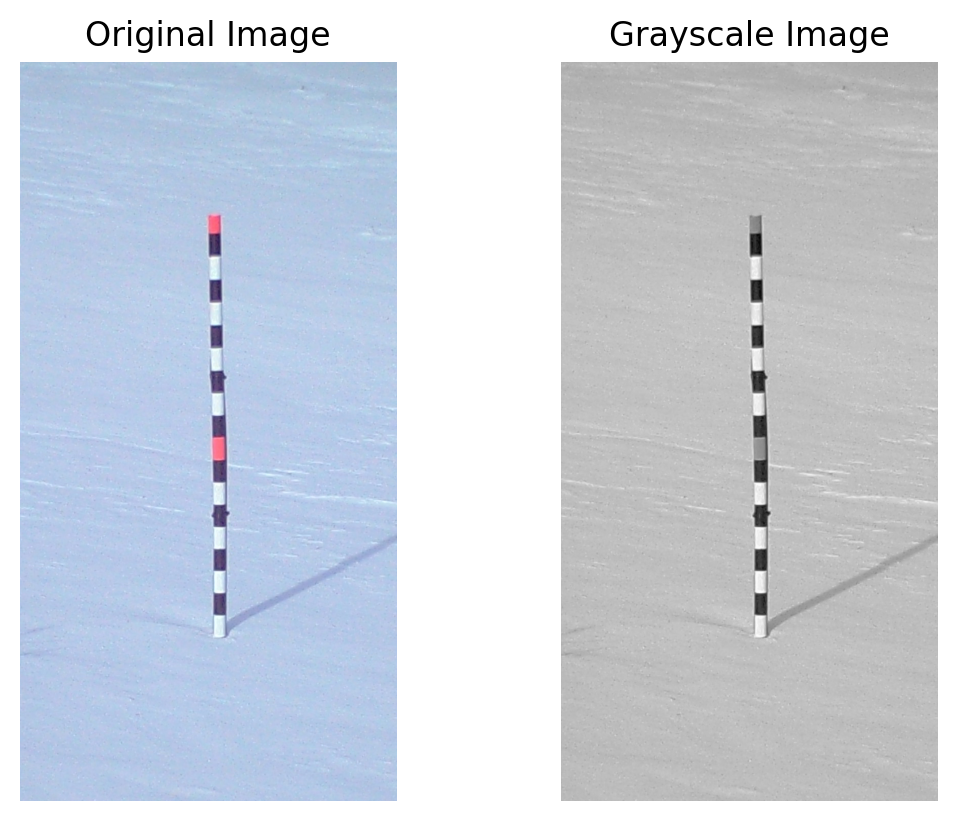

In [34]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'SnowPole_Crop.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the grayscale image
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Display the plot
plt.show()


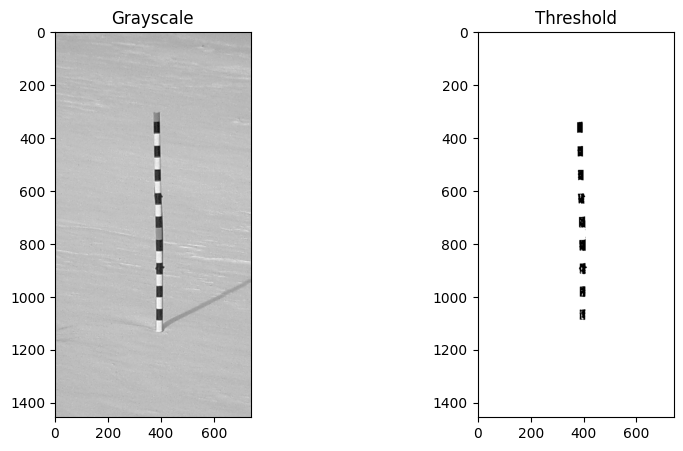

There are 10 black marks in the photo
The estimated snow depth is: 50cm +/- 5cm


In [34]:
# Load the (grayscale) image and make a plot
img = cv2.imread('SnowPole_Crop.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img_gray,cmap='gray')
axs[0].set_title('Grayscale')

thres_value, img_binary = cv2.threshold(img_gray,90,255,cv2.THRESH_BINARY)
axs[1].imshow(img_binary,cmap='gray')
axs[1].set_title('Threshold')
plt.show()

# Applying Segmentation

# this value defines what is "connected" - it is either 4 (edges only) or 8 (diagonals OK)
connectivity = 4

# get the connected components:
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity, cv2.CV_32S)

# loop over the components, and if their areas are above the required size, add them to the map.
minArea = 5
mask=np.zeros(np.shape(img_binary))
count=0
for i in range(numLabels):
    area = stats[i,cv2.CC_STAT_AREA]
    # note, we skip label 1 because this is the largest - usually the background of the image!
    if i>0 and area > minArea:
        #componentMask = (labels == i).astype("uint8") * 255
        #mask = cv2.bitwise_or(mask, componentMask)
        count += 1
        object_mask = (labels == i)
        mask[object_mask] = area
        
# make any areas that are still zero into nan, for a white background:
mask[mask==0] = np.nan

# Estimated snow depth
blackmarks = count
snowdepth = (30 - (blackmarks*2))*5

print(f'There are {blackmarks} black marks in the photo')
print(f'The estimated snow depth is: {snowdepth}cm +/- 5cm')

#### Try Again:
Try with a second image with a deeper snow depth (less markings visible).
<br>
<br>
<img src="SnowPole2_Crop.jpg" alt="drawing" width="200"/>

In [36]:
# Applying Segmentation

# this value defines what is "connected" - it is either 4 (edges only) or 8 (diagonals OK)
connectivity = 4 

# get the connected components:
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary, connectivity, cv2.CV_32S)

# loop over the components, and if their areas are above the required size, add them to the map.
minArea = 5
mask=np.zeros(np.shape(img_binary))
count=0
for i in range(numLabels):
    area = stats[i,cv2.CC_STAT_AREA]
    # note, we skip label 1 because this is the largest - usually the background of the image!
    if i>0 and area > minArea:
        #componentMask = (labels == i).astype("uint8") * 255
        #mask = cv2.bitwise_or(mask, componentMask)
        count += 1
        object_mask = (labels == i)
        mask[object_mask] = area
        
# make any areas that are still zero into nan, for a white background:
mask[mask==0] = np.nan

# Estimated snow depth
blackmarks = count
snowdepth = (30 - (blackmarks*2))*5

print(f'There are {blackmarks} black marks in the photo')
print(f'The estimated snow depth is: {snowdepth}cm +/- 5cm')

There are 6 black marks in the photo
The estimated snow depth is: 90cm +/- 5cm


#### Conclusion:

This is a start to what we want to accomplish since the image has been cropped and Tthe above code is only counting the black marks. This only offers a limited accuracy, within +/- 5cm, because it assumes that for every black mark there is also a white (or orange) mark visible. To make this more useful, the code will have to be able to either automatically crop or automatically identify the snow pole in the image. Then it will have to be able to count all the markings for a more accurate snow depth estimate. It would be also useful to identify the date and temperature reading in the image and store all this information in a data. There will be a large of amount of images to work through, therefore, the most useful feature would then be if this code could process all the images in a season and plot temperature and snow depth for the entire season.